# ResNet 2016a : He et al

### Step0 : Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm


### Step1 : Original VGG16

In [2]:
class VGG16(nn.Module):
    def __init__(self,in_channels=3,out_classes=1000):
        super().__init__()
        # 224*244
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.ReLU())
        # 112*112
        self.block2=nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.ReLU(),
        )
        # 56*56
        self.block3=nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(),
        )
        # 28*28
        self.block4=nn.Sequential(
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(),
        )
        # 14*14
        self.block5=nn.Sequential(
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(),
        )
        # 7*x7
        self.maxpool = nn.MaxPool2d((2,2))
        self.linear1=nn.Linear(7*7*512,4096)
        self.linear2=nn.Linear(4096,4096)
        self.out=nn.Linear(4096,out_classes)
    def forward(self,x):
        x=self.block1(x)
        x=self.maxpool(x)

        x=self.block2(x)
        x=self.maxpool(x)

        x=self.block3(x)
        x=self.maxpool(x)

        x=self.block4(x)
        x=self.maxpool(x)
        
        x=self.block5(x)
        x=self.maxpool(x)
        
        x=self.pool(x)
        x=x.view(x.size(0), -1)

        x=self.linear1(x)
        x=self.linear2(x)
        x = self.out(x)
        return x

### Step2 : Papers section 4.2 CIFAR-10 and Analysis

In [3]:
class PlainNetwork(nn.Module):
    def __init__(self,in_channels=3,out_classes=10,n=10):
        super().__init__()
        # 32x32
        self.block0 =nn.Sequential(
            nn.Conv2d(in_channels,16,kernel_size=3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.block1 = nn.ModuleList()
        for i in range(2*n):
            self.block1.append(
                nn.Sequential(
                    nn.Conv2d(16,16,kernel_size=3,padding=1,stride=1),
                    nn.BatchNorm2d(16),
                    nn.ReLU()
                )
            )
        self.block2 = nn.ModuleList()
        self.block2.append(     
            nn.Sequential(
                    nn.Conv2d(16,32,kernel_size=3,padding=1,stride=2),
                    nn.BatchNorm2d(32),
                    nn.ReLU()
            )
        )
        for i in range(2*n-1):
            self.block2.append(
                nn.Sequential(
                    nn.Conv2d(32,32,kernel_size=3,padding=1,stride=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU()
                )
            )

        self.block3 = nn.ModuleList()
        self.block3.append(     
            nn.Sequential(
                    nn.Conv2d(32,64,kernel_size=3,padding=1,stride=2),
                    nn.BatchNorm2d(64),
                    nn.ReLU()
            )
        )
        for i in range(2*n-1):
            self.block3.append(
                nn.Sequential(
                    nn.Conv2d(64,64,kernel_size=3,padding=1,stride=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU()
                )
            )

        self.pool= nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(1*1*64,out_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    def forward(self,x):
        x = self.block0(x)
        for layer in self.block1:
            x= layer(x)

        for layer in self.block2:
            x= layer(x)

        for layer in self.block3:
            x= layer(x)
        
        x=self.pool(x)
        x=x.view(x.size(0), -1)

        x = self.fc(x)
        return x

### Step3 : prepare Data

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device ",device)

BATCH_SIZE = 196

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4,pin_memory=True,persistent_workers=True)
    
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)

device  cuda


### Step4: Training Loop

In [5]:

def train(model,num_epochs=164):
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[82, 123], gamma=0.1)

    train_accs, test_accs = [], []

    epoch_bar = tqdm(range(num_epochs), desc="Epochs", position=0)
    for epoch in epoch_bar:
        model.train()
        total, correct = 0, 0
        
        for inputs, targets in tqdm(trainloader, desc="Training", leave=False, position=1):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = 100. * correct / total
        train_accs.append(train_acc)
        scheduler.step()

        model.eval()
        total, correct = 0, 0
        for inputs, targets in tqdm(testloader, desc="Validation", leave=False, position=1):
            with torch.no_grad():
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_acc = 100. * correct / total
        test_accs.append(test_acc)
        
        epoch_bar.set_postfix({"Train": train_acc, "Test":test_acc, "LR": optimizer.param_groups[0]['lr']})

    return train_accs, test_accs

### Step5 : Baseline + degradation


--- EXPERIMENT A: Plain-20 (Shallow) ---


Epochs: 100%|██████████| 164/164 [08:59<00:00,  3.29s/it, Train=98.8, Test=90.6, LR=0.001]



--- EXPERIMENT B: Plain-56 (Deep) ---


Epochs: 100%|██████████| 164/164 [24:24<00:00,  8.93s/it, Train=95.9, Test=86.4, LR=0.001]


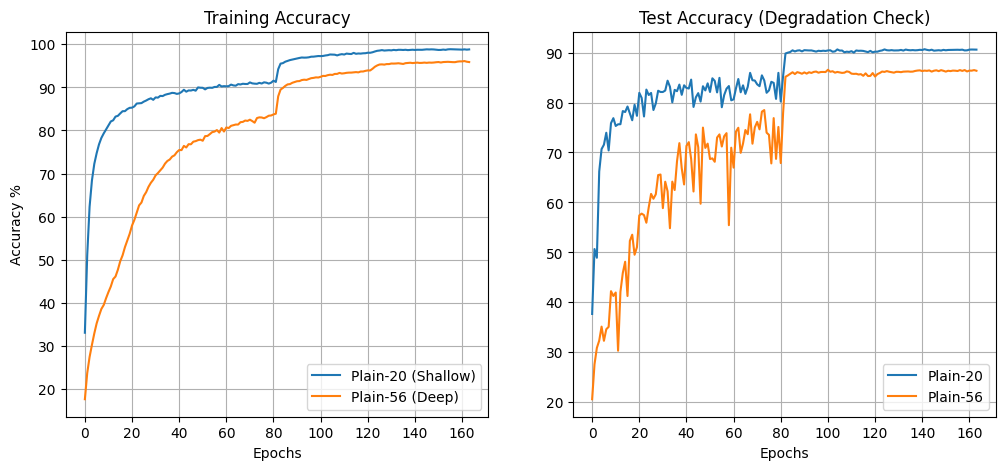

In [6]:
print("\n--- EXPERIMENT A: Plain-20 (Shallow) ---")
plain20 = PlainNetwork(n=3)
hist20 = train(plain20) 

print("\n--- EXPERIMENT B: Plain-56 (Deep) ---")
plain56 = PlainNetwork(n=9)
hist56 = train(plain56)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(hist20[0], label='Plain-20 (Shallow)')
plt.plot(hist56[0], label='Plain-56 (Deep)')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist20[1], label='Plain-20')
plt.plot(hist56[1], label='Plain-56')
plt.title('Test Accuracy (Degradation Check)')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)

plt.savefig('degradation_plot.png')
plt.show()

### Step6: Residual networks

In [ ]:
class ResidualNetwork(nn.Module):
    def __init__(self,in_channels=3,out_classes=10,n=10):
        super().__init__()
        # 32x32
        self.block0 =nn.Sequential(
            nn.Conv2d(in_channels,16,kernel_size=3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        # ----------------- BLOCK1 ----------------------
        self.block1 = nn.ModuleList()
        for i in range(n):
            self.block1.append(
                nn.Sequential(
                    nn.Conv2d(16,16,kernel_size=3,padding=1,stride=1),
                    nn.BatchNorm2d(16),
                    nn.ReLU()
                ),
            )
            self.block1.append(
                nn.Sequential(
                    nn.Conv2d(16,16,kernel_size=3,padding=1,stride=1),
                    nn.BatchNorm2d(16),
                ),
            )

        # ----------------- BLOCK2 ----------------------
        self.block2 = nn.ModuleList()

        self.block2.append(     
            nn.Sequential(
                    nn.Conv2d(16,32,kernel_size=3,padding=1,stride=2),
                    nn.BatchNorm2d(32),
                    nn.ReLU()
            )
        )
        self.block2.append(
                nn.Sequential(
                    nn.Conv2d(32,32,kernel_size=3,padding=1,stride=1),
                    nn.BatchNorm2d(32),
                )
            )
        for i in range(n-1):
            self.block2.append(
                nn.Sequential(
                    nn.Conv2d(32,32,kernel_size=3,padding=1,stride=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU()
                )
            )
            self.block2.append(
                nn.Sequential(
                    nn.Conv2d(32,32,kernel_size=3,padding=1,stride=1),
                    nn.BatchNorm2d(32),
                )
            )
        # ----------------- BLOCK3 ----------------------
        self.block3 = nn.ModuleList()

        self.block3.append(     
            nn.Sequential(
                    nn.Conv2d(32,64,kernel_size=3,padding=1,stride=2),
                    nn.BatchNorm2d(64),
                    nn.ReLU()
            )
        )
        self.block3.append(
                nn.Sequential(
                    nn.Conv2d(64,64,kernel_size=3,padding=1,stride=1),
                    nn.BatchNorm2d(64),
                )
        )
        for i in range(n-1):
            self.block3.append(
                nn.Sequential(
                    nn.Conv2d(64,64,kernel_size=3,padding=1,stride=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU()
                )
            )
            self.block3.append(
                nn.Sequential(
                    nn.Conv2d(64,64,kernel_size=3,padding=1,stride=1),
                    nn.BatchNorm2d(64),
                )
            )

        self.pool= nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(1*1*64,out_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    def forward(self,x):

        x = self.block0(x)

        for idx in range(0, len(self.block1), 2):
            skip = x
            x = self.block1[idx](x) 
            x = self.block1[idx+1](x)
            x = x + skip

        for idx in range(0, len(self.block2), 2):
            skip = x
            x = self.block2[idx](x) 
            x = self.block2[idx+1](x)
            if idx == 0:

                

                skip =skip[:,:,::2,::2]() # width/2,height/2

                # skip shape (Batch, Channels, Height, Width)

                
                skip= F.pad(skip, (0, 0, 0, 0, 0, 16))
                # (0,0)  Width: Add 0 pixels left, 0 pixels right. 
                # (0,0)  Height: Add 0 pixels top, 0 pixels bottom.
                # (0,32) Channels: Add 0 channels at the start, 16 channels at the end.

            x = x + skip
            x= F.relu(x)
        for idx in range(0, len(self.block3), 2):
            skip = x
            x = self.block3[idx](x) 
            x = self.block3[idx+1](x)
            if idx == 0:
                skip =skip[:,:,::2,::2] # width/2,height/2
                skip = F.pad(skip, (0, 0, 0, 0, 0, 32))
            x = x + skip
        
        x=self.pool(x)
        x=x.view(x.size(0), -1)

        x = self.fc(x)
        return x

### ResNet Results


--- EXPERIMENT A: Resnet-20 (Shallow) ---


Epochs: 100%|██████████| 164/164 [09:12<00:00,  3.37s/it, Train=99, Test=90.9, LR=0.001]  



--- EXPERIMENT B: Resnet-56 (Deep) ---


Epochs: 100%|██████████| 164/164 [24:49<00:00,  9.08s/it, Train=99.9, Test=92.8, LR=0.001]


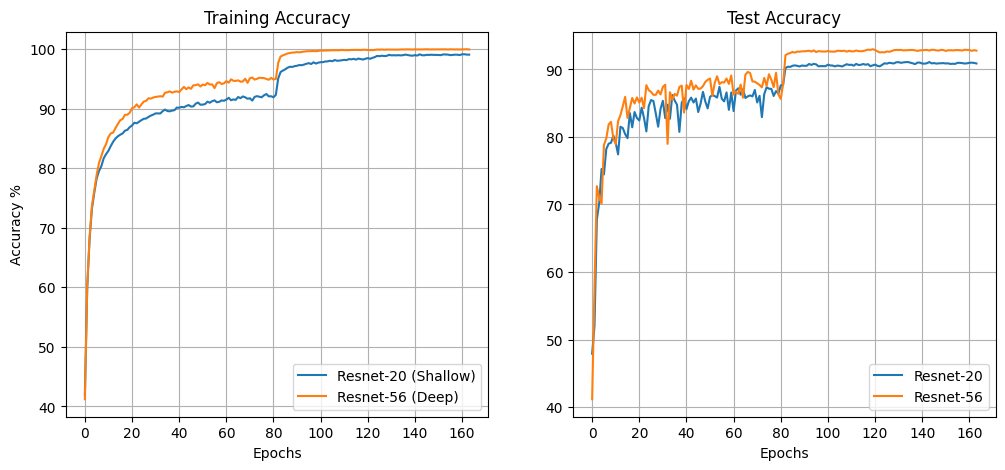

In [8]:
print("\n--- EXPERIMENT A: Resnet-20 (Shallow) ---")
resnet20 = ResidualNetwork(n=3)
hist20 = train(resnet20) 

print("\n--- EXPERIMENT B: Resnet-56 (Deep) ---")
resnet56 = ResidualNetwork(n=9)
hist56 = train(resnet56)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(hist20[0], label='Resnet-20 (Shallow)')
plt.plot(hist56[0], label='Resnet-56 (Deep)')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist20[1], label='Resnet-20')
plt.plot(hist56[1], label='Resnet-56')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)

plt.savefig('resnet_results.png')
plt.show()